<a href="https://colab.research.google.com/github/antonium85/stock-trading-analysis/blob/main/stock_sma50vs100_algo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install yahoo_fin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 81 kB 8.7 MB/s 
     |████████████████████████████████| 83 kB 2.0 MB/s 
     |████████████████████████████████| 112 kB 72.5 MB/s 
     |████████████████████████████████| 127 kB 71.1 MB/s 
  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-py3-none-any.whl size=13502 sha256=fbccf5054bf6ae262febcaef44a23e58f3ff71b090e29027a7159e2b6eddfd6c
  Stored in directory: /root/.cache/pip/wheels/ed/f7/62/50ab6c9a0b5567267ab76a9daa9d06315704209b2c5d032031
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24591 sha256=3a5db1cb099b95d56853b3cbe427857b7bbc5edc7353299a020cd8fbcdec7f0e
  Stored in directory: /root/.cache/pip/wheels/9c/aa/cc/f2228050ccb40f22144b073f15a2c84f11204f29fc0dce028e
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6066 sha256=8ec2638f4d2bad0cb83afc9794a93970007d08d3ea51dd4257d72

In [ ]:
pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29104 sha256=2f1c3a4a4aed68ba5bf748dfd548ba629e3659d632a8baeff8ffdabcf5d893eb
  Stored in directory: /root/.cache/pip/wheels/31/31/f1/f2ff471bbc5b84a4b973698ceecdd453ae043971791adc3431
Successfully built ta


In [ ]:
import pandas as pd
import ta
from yahoo_fin.stock_info import get_data
from datetime import datetime, timedelta
import time

In [ ]:
def get_historical_datas(ticker, interval):
  if interval == '1d':
    end_date = datetime.today()
  elif interval == '1wk':
    end_date = datetime.today() #- timedelta(1)
  start_date = end_date - timedelta(365*8)

  #print("End date = ", end_date.strftime('%d-%m-%Y'))
  #print("Start date = ", start_date.strftime('%d-%m-%Y'))

  # replace ^FCHI (CAC40) by what you want AMZN, GOOG, META ...
  output = get_data(ticker, start_date=start_date.strftime('%d/%m/%Y'), end_date=end_date.strftime('%d/%m/%Y'), index_as_date = True, interval=interval)

  #del(output)
  output['close'] = pd.to_numeric(output['close'])
  output['high'] = pd.to_numeric(output['high'])
  output['low'] = pd.to_numeric(output['low'])
  output['open'] = pd.to_numeric(output['open'])

  output['SMA25'] = ta.trend.sma_indicator(output['close'], 25)
  output['SMA50'] = ta.trend.sma_indicator(output['close'], 50)
  output['SMA100'] = ta.trend.sma_indicator(output['close'], 100)
  output['SMA99'] = ta.trend.sma_indicator(output['close'], 99)
  output['SMA200'] = ta.trend.sma_indicator(output['close'], 200)

  return output

In [ ]:
#print("End date = ", end_date.strftime('%d-%m-%Y'))
#print("Start date = ", start_date.strftime('%d-%m-%Y'))

ticker_list = ["NFLX","PYPL","TSLA","AMZN","AAPL","GOOG","META","MSFT","MNTV","ADBE","NVDA","V","NKE"] 

historical_datas = {}
weekly_historical_datas = {}
for ticker in ticker_list:
  print(ticker)
  
  historical_datas[ticker] = get_historical_datas(ticker, '1d')
  weekly_historical_datas[ticker] = get_historical_datas(ticker, '1wk')

NFLX
PYPL
TSLA
AMZN
AAPL
GOOG
META
MSFT
MNTV
ADBE
NVDA
V
NKE


# SMA Trading Algo
*   Cross SMA50 vs SMA100 : work well for TSLA, NFLX, PYPL
*   Cross SMA100 vs SMA200 : work well for WLN.PA, CDI.PA

In [ ]:
dt = pd.DataFrame(columns = ['last action', 'date', 'traded price','actual price','wallet','pnl'])
result = dict()
lastAction=''
lastIndex = ''
lastPrice = ''
for ticker in ticker_list:
  usd = 300
  share = 0

  df = historical_datas[ticker].copy()
  for index, row in df.iterrows():
    if row['SMA50'] > row['SMA100'] and usd > 10:
      share = usd / df['close'][index] 
      usd = 0
      
      lastIndex = index
      lastAction = 'buy'
      lastPrice = row['close']

    if row['SMA50'] < row['SMA100'] and share > 1:
      usd = share * df['close'][index]
      share = 0
      
      lastIndex = index
      lastAction = 'sell'
      lastPrice = row['close']

  finalResult = usd + share * df['close'].iloc[-1]
  result[ticker] = finalResult
  pnl = (finalResult - 300)/300 * 100

  myrow = pd.DataFrame({'last action':lastAction,'date':lastIndex,'traded price':lastPrice,'actual price':df['close'].iloc[-1],'wallet':finalResult,'pnl':pnl},index=[ticker])
  dt = pd.concat([dt,myrow])
  #print("Final result for ",ticker,' : ',finalResult,'$')
  #print('Ticker ',ticker,' last action ',lastAction,' date :',lastIndex,' price : ',lastPrice)

dt.sort_values(by="pnl",ascending=False)

,last action,date,traded price,actual price,wallet,pnl
NVDA,sell,2022-02-22,233.899994,124.660004,7871.051418,2523.683806
TSLA,buy,2022-09-01,277.160004,214.440002,4277.942678,1325.980893
NFLX,buy,2022-08-31,223.559998,289.570007,2085.900038,595.300013
AMZN,buy,2022-08-30,128.729996,119.320000,1087.657352,262.552451
MSFT,sell,2022-10-11,225.410004,242.119995,1001.501556,233.833852
AAPL,buy,2022-08-26,163.619995,147.270004,907.769565,202.589855
ADBE,sell,2022-09-19,296.059998,306.369995,759.811893,153.270631
PYPL,buy,2022-09-01,92.660004,83.940002,698.540827,132.846942
GOOG,sell,2022-09-19,103.849998,101.480003,654.089792,118.029931
V,sell,2022-09-30,177.649994,190.369995,441.806288,47.268763


Last price :  147.27000427246094
SMA50[-1] =  154.10699951171875
SMA100[-1] =  151.20860000610352


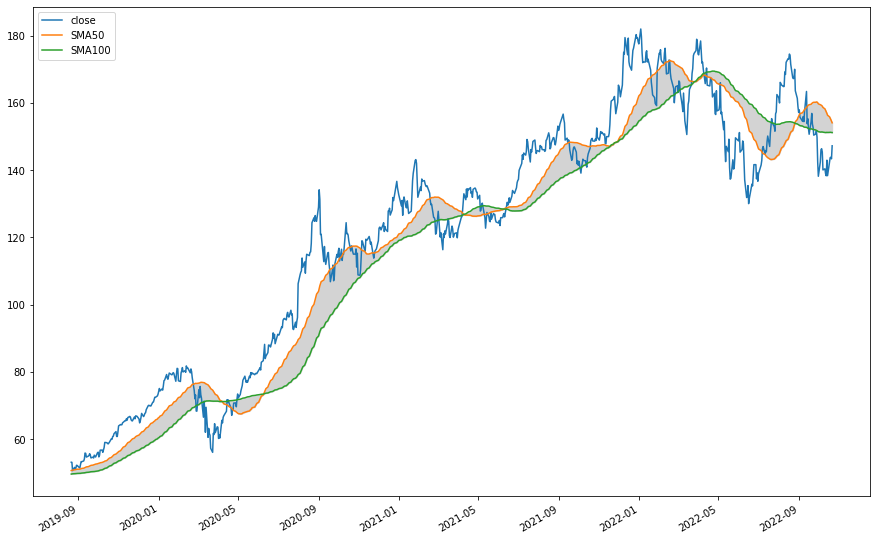

In [ ]:
import matplotlib

ticker_test = 'AAPL'

print('Last price : ',historical_datas[ticker_test]['close'].iloc[-1])

print('SMA50[-1] = ',historical_datas[ticker_test]['SMA50'].iloc[-1])
print('SMA100[-1] = ',historical_datas[ticker_test]['SMA100'].iloc[-1])

#df[['close','SSA','SSB']].iloc[-600:].plot(figsize=(20,10))
tmp = historical_datas[ticker_test][['close','SMA50','SMA100']].tail(800)
a1 = tmp.plot(figsize=(15,10))
a1.fill_between(tmp.index, tmp.SMA50, tmp.SMA100,color='lightgrey')